In [1]:
%matplotlib inline
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams['figure.figsize'] = (10.0, 5.0)

# Практическое введение в теорию скирмионов

Мы занимаемся изучением магнитными кристаллами и некоторыми другими магнитными системами.
Магнитный кристалл состоит из атомов обладающих спином, расположенных в вершинах некоторой решетки. 
Магнитные системы демонстрируют мпногообразие состояний, многие из которых находят применение на практике, нас наиболее интересуются [скирмионы](https://en.wikipedia.org/wiki/Magnetic_skyrmion).

В [классической модели Гейзенберга](https://en.wikipedia.org/wiki/Classical_Heisenberg_model) каждый спин задается с помощью одного трехмерного вектора $s_j$  единичной длины $\|s_j\|=1$, здесь $j$ обозначает номер узла решетки. 
Также часто рассматривается вектор магнитного момента $S_j=\mu_0 s_j$, где величина магнитного момента $\mu_0>0$ одинакова для всех узлов.

Динамика системы описывается [уравнениями Ландау-Лифшица](https://en.wikipedia.org/wiki/Landau%E2%80%93Lifshitz%E2%80%93Gilbert_equation), являющимися частным случаем [гамильтоновой механики](https://en.wikipedia.org/wiki/Hamiltonian_mechanics),
$$\frac{d S_j}{dt}=-\gamma S_j\times H_j,$$ 
где $\times$ обозначает векторное произведение.
Константа $\gamma$ называется [гиромагнитным отношением](https://en.wikipedia.org/wiki/Gyromagnetic_ratio), вектор $H_j$ задает эффективное магнитное поле для узла $j$.
Эффективное поле в простейшем случае выбирается в виде
$$H_j=-\frac{\partial E}{\partial S_j},$$
где $E$~-- функционал энергии поля $S$, а $\frac{\partial}{\partial S_j}$ обозначает градиент по переменной $S_j$.
Для диссипативной среды уравнение движения содержит дополнительный диссипативный член, член Гильберта:
$$\frac{d S_j}{dt}=-\gamma S_j\times H_j-\alpha\frac{\gamma}{\mu_0}S_j\times(S_j\times H_j),$$ 
где $\alpha$~-- безразменный коэффициент диссипации.

## Функционал энергии

Функционал энергии может содержать различные слагаемые, в зависимости от того, какими вкладами энергии мы принебрегаем. 
Часто энергия берется в виде, учитывающем только короткодействующие взаимодействия:
$$E[S]=-\sum_n B_n\cdot S_n
-K_0\sum_{n}|K\cdot s_n|^2
-\sum_{<n,m>}J_{n,m}s_n\cdot s_m
-\sum_{<n,m>}D_{n,m}\cdot(s_n\times s_m),$$
где $\cdot$ обозначает скалярное произведение.
Здесь первое слагаемое равно энергии взаимодействия с внешним магнитным полем напряженности $B$.
Второе слагаемое отвечает энергии анизотропии, здесь $K$ - единичный вектор анизотропиии, $K_0$ - величина анизотропии.
Третье слагаемое дает энергию обменного взаимодействия, здесь $J_{n,m}$ величина взамодействия между узлавми $n$ и $m$.
Суммирование ведется по всем парам узлов, т.о. можно положить $n<m$ для случая, когда индекс является числом.
Четвертое слагаемое отвечает [взаимодействию Дзялошинского-Мория](https://en.wikipedia.org/wiki/Antisymmetric_exchange), здесь $D_{n,m}$ - вектор, задающий взаимодействие для пары $n,m$.
Обменное взаимодействие $J$ симметрично $J_{n,m}=J_{m,n}$, а взаимодействие Д-М антисимметрично $D_{n,m}=-D_{m,n}$.
Вектор Д-М обычно выбирают в одном из двух видов: либо $D_{n,m}$ направлено в направлении радиус-вектора $R_{n,m}$ между спинами $n$ и $m$, либо $D_{n,m}$ ортогорнально $R_{n,m}$ и лежит в плоскости системы.

В ряде случаев важную роль играет дальнодействующее дипольное взаимодействие, в этом случае к энергии добавляется слагаемое:
$$E[S]=\ldots-\frac{\mu_0}{8\pi}\sum_{<n,m>}\frac{3(S_n\cdot r_{n,m})(S_m\cdot r_{n,m})-S_n\cdot S_m}{R_{n,m}^3}.$$
Вектор $r_{n,m}=R_{n,m}/\|R_{n,m}\|$ обозначает нормированный на единицу вектор $R_{n,m}$. 
Вычисление дипольного взаимодействия значительно медленнее, чем короткодействующих взаимодействий.
В ряде случаев дипольное взаимодействие можно учесть, заменив анизотропию на эффективную анизотропию, тогда слагаемое с дипольным взаимодействием можно отбросить.

Бывает удобно учитывать, что функционал энергии является квадратичной функцией от $S_j$,
т.е. его можно записать в виде:
$$E[S]=\frac12\langle S|QS\rangle+\langle L|S\rangle,$$
для подходящего вектора $L$ и матрицы $Q$.
Здесь угловые скобки обозначают скалярное произведение в пространстве векторных полей:
$$\langle S|\tilde S\rangle=\sum_n S_n\cdot \tilde S_n.$$
В таком представлении легко считается градиент энергии:
$$\frac{\partial}{\partial S}E[S]=QS+L.$$

## Прямоугольная решетка

Прямоугольная решетка состоит из копий одного узла (расположим его в начале координат), полученных его трансляциями на базисные вектора.
Т.е. узлы расположены в точках $(n\delta,m\delta)$, где $\delta$ - шаг решетки, $n$ и $m$ - целые числа.
Каждый узел взаимодействует с $4$ ближайшими соседями.
Пусть магнитное поле и вектор анизотропии направлены перпендикулярно плоскости системы, т.е. напряженность имеет вид $B=(0,0,B)$ и $K=(0,0,1)$.
Вектор Д-М направим перпендикулярно радиус векторам между точками и расположим их в плоскости системы.
Обозначим через $e_x$ и $e_y$ вектора ортонормированного базиса в плоскости системы.
Вектор спина в точке $(n,m)$ обозначаем $S_{n,m}=(S_{n,m;x},S_{n,m;y},S_{n,m;z})$.
Тогда функционал энегии принимает следующий явный вид:
$$E[S]=-K\sum_{n,m}|s_{n,m;z}|^2-J(\sum_{n,m}s_{n,m}\cdot s_{n-1,m}+\sum_{n,m}s_{n,m}\cdot s_{n,m-1})-D(\sum_{n,m}e_y\cdot(s_{n,m}\times s_{n-1,m})-e_x\cdot(s_{n,m}\times s_{n,m-1}))-\mu_0 B\cdot\sum_{n,m} s_{n,m;z},$$
здеcь суммы берутся по всем узлам $n,m$.

Вектороное поле $s$ удобно хранить в виде массива размера $N\times N\times 3$, где первые два индекса задают узел решетки, а последний индекс выбирает координату трехмерного вектора спина.
Введем несколько вспомогательных функций для работы с векторными полями.

In [2]:
# Эта функция считает скалярное произведение двух векторных полей 
# как сумму скалярных произведений по отдельным узлам
def inner(x,y): return np.sum(x*y)

# Соответсвующая скалярному произведению выше норма
def norm(x): return np.sqrt(inner(x,x))

# Эта функциянормирует каждый вектор векторного поля на единицу.
# С помощью этой функции произвольное векторное поле можно заменить на ближайшее поле
# удовлетворяющее условию нормировки на векора $s_n$
def normalize(x): return x/np.expand_dims(np.sqrt(np.sum(x*x,axis=-1)),-1)

In [3]:
# Энергию удобно записать через матрицу квадратичной части и линейную часть
def E(x): return inner(x,Q(x))/2+inner(x,L)

# Тогда градиент имеет совсем простой вид
def gradE(x): return Q(x)+L

# Зафиксируем размер решетки
N=30

# Линейная часть равна L_n=-\mu_0 B_n
B=0.1 # напряженность внешнего магнитного поля
mu0=1 # величина магнитного момента
L=np.zeros((N,N,3)); L[:,:,2]=-mu0*B

# Явный вид матрицы квадратичной формы можно получить как второй дифференциал энергии
J=1. # обменное взаимодействие
K=0.07 # анизотропия
D=0.32 # Д-М
def Q(x): 
    y=np.zeros(x.shape)
    y[:,:,2]=-2*K*x[:,:,2]
    t=J*x
    y[1:,:]-=t[:-1,:]; y[:-1,:]-=t[1:,:]
    y[:,1:]-=t[:,:-1]; y[:,:-1]-=t[:,1:]
    t=D*x
    y[1:,:,2]+=t[:-1,:,0]; y[:-1,:,0]+=t[1:,:,2]
    y[1:,:,0]-=t[:-1,:,2]; y[:-1,:,2]-=t[1:,:,0]
    y[:,1:,1]+=t[:,:-1,2]; y[:,:-1,2]+=t[:,1:,1]
    y[:,1:,2]-=t[:,:-1,1]; y[:,:-1,1]-=t[:,1:,2]
    return y

Теперь мы можем создать случайное поле и посчитать энергию этой конфигурации

In [4]:
s0=normalize(np.random.randn(*L.shape))
print('Energy', E(s0))

Energy -26.8082179657


In [5]:
cdict={'red': ((0.0, 0.0, 0.0), (0.5, 0.0, 0.0), (1.0, 1.0, 1.0)),
        'green': ((0.0, 0.0, 0.0), (0.5, 0.0, 0.0), (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0), (0.5, 0.0, 0.0), (1.0, 0.0, 0.0))
        }
plt.register_cmap(name='blueblackred', data=cdict)

def plot_field(s):
    fig,axis=plt.subplots()
    axis.set_aspect('equal')
    plt.axis("off")
    x,y=np.mgrid[0:s.shape[0], 0:s.shape[1]]
    plt.set_cmap('blueblackred')
    Q=axis.quiver(x,y,s[:,:,1],s[:,:,0],s[:,:,2],angles='xy',scale_units='xy',pivot="mid",scale=1,clim=(-1,1))
    axis.set_xlim([-1,s.shape[0]])
    axis.set_ylim([-1,s.shape[1]])
    return (fig,axis,Q)

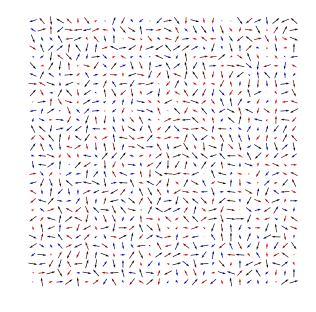

In [6]:
plot_field(s0)
plt.show()

## Метастабильные состояния

Важным вопросом является нахождение состояний с минимальной энергией, 
так как для физических систем такие состояния предпочтительны, 
и система будет находится в таком состоянии при нуле температуры.
Глобальные минимум систем дает нам основное стабильное состояние.
Однако система может находится и в одном из локальных минимумов энергии, 
называемых метастабильными состояниями.
Для нахождения минимума воспользуемся простейшим методом минимизации - градиентыми спуском.

In [7]:
def minimize(s, step=1, maxiter=100):
    for i in range(maxiter): s=normalize(s-gradE(s)*step)
    return s

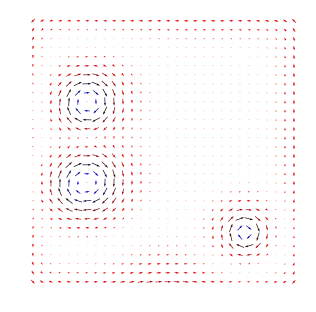

In [8]:
s=minimize(s0)
plot_field(s)
plt.show()

Получившееся внутри области локализованное состояние называется скирмион и исследование таких состояний представляет для нас наибольший интерес.

Чтобы оценить точность нахождения минимума найдем норму проекции градиента на касательное подпространство к пространству полей векторов единичной длины. 

In [9]:
# Функция проектирует ветора ds на касательные плоскости к единичным сферам, 
# проведенным в точках s0.
def tangent(s0, ds):
    return ds-np.expand_dims(np.sum(s0*ds, axis=-1),-1)*s0

In [10]:
print('Error', norm(tangent(s, gradE(s))))

Error 0.71832573286


## Моделирование динамики

Если решение не стационарное, то оно должно изменять во времени. 
Рассмотрим его динамику.
Будем интегрировать уравнение движения простейшим способом, методом Эйлера.
Заметим, что этот метод не сохраняет энергию и длины векторов.

In [11]:
# Функция делает N шагов длины dt метода Эйлера для решения уравнения Л-Л.
# На вход поступает функция в момент t0, на выходе функция в момент времени t0+N*dt.
gamma=0.2 # гиромагнитное отношение
def propagate(s0, N=100, dt=0.01):
    s=s0.copy()
    for n in range(N):
        s+=(dt*gamma)*np.cross(gradE(s),s)
    return normalize(s)

In [12]:
# шаблон функции для анимаций
def animate(init, update, N, interval=50):
    fig,data=init()
    anim=animation.FuncAnimation(fig, lambda i: update(i, data), frames=N, interval=interval, blit=False)
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

# выводим видео с динамикой, всего N кадров
def plot_dynamics(s0, N=100):
    s=s0
    def init(): 
        fig,ax,Q=plot_field(s)
        return (fig, Q)
    def update(_, Q):
        global s
        s=propagate(s)
        Q.set_UVC(s[:,:,1],s[:,:,0],s[:,:,2])
        return Q
    return animate(init, update, N)

In [13]:
plot_dynamics(s)

## Библиотека для работы с произвольными решетками

In [14]:
import miser3 as miser

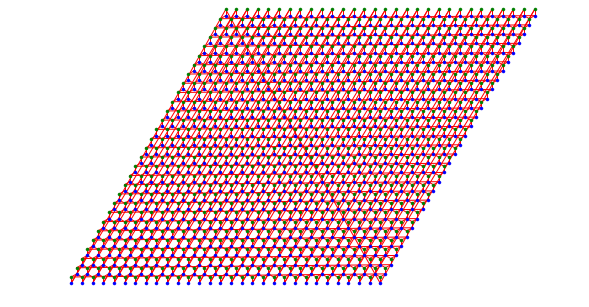

In [16]:
# создадим гексагональную решетку и нарисуем ее
lat=miser.LatticeHexagonal()
lat.plot()
plt.show()

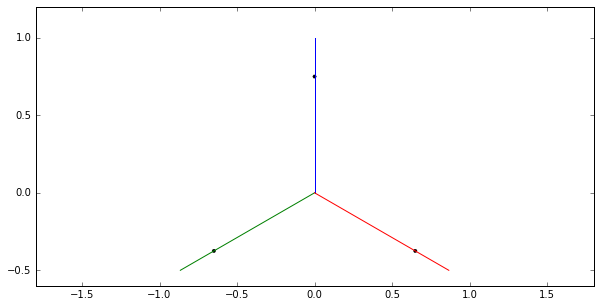

In [17]:
# отрисуем фундаментальную ячейку и вектора Д-М
lat.plot_stencil()
plt.show()

In [18]:
# всякая решетка задаеся векторами, на которую ее можно транслировать без изменений,
print('Трансляции\n', lat.translations)
# минимальным набором вершин, таким что остальные можено получить трансляциями,
print('Координаты вершин в фундаментальной ячейке\n', lat.cell)
# минимальным набором ребер, так что остальные получаются трансляциями
print('Минимальный набор ребер: [номер ячейки], узел в ячейке, узел в фундаментальной ячейке\n', lat.bonds)
# размерами решетки
print('Число ячеек по каждой оси\n', lat.size)
# Каждое ребро задает коороткодействующее взамиодействие между парой спинов.
# Для каждого ребра задаютя параметры всех взаимодействий
print('Коэффициенты обменного взаимодействия\n', lat.J)
print('Вектора Д.-М.\n', lat.D)
# Анизотропия и магинтное поле общее для всех спинов
print('Анизотропия\n', lat.K, '*', lat.K0)
print('Внешнее магнитное поле\n', lat.H)

Трансляции
 [[ 1.7320508  0.       ]
 [ 0.8660254  1.5      ]]
Координаты вершин в фундаментальной ячейке
 [array([ 0.,  0.]), array([0, 1])]
Минимальный набор ребер: [номер ячейки], узел в ячейке, узел в фундаментальной ячейке
 [([0, 0], 1, 0), ([0, 1], 1, 0), ([-1, 1], 1, 0)]
Число ячеек по каждой оси
 (30, 30)
Коэффициенты обменного взаимодействия
 [1.0, 1.0, 1.0]
Вектора Д.-М.
 [[ 0.  0.  0.]
 [ 0. -0.  0.]
 [-0. -0.  0.]]
Анизотропия
 [ 0.] * [[0 0 1]]
Внешнее магнитное поле
 [ 0.  0.  0.]


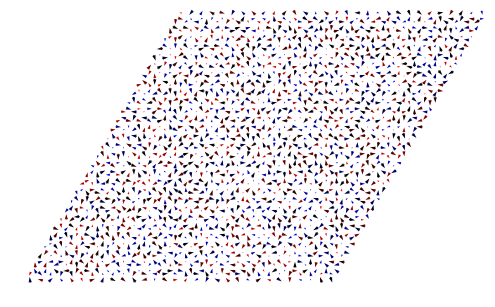

In [19]:
# сгенерируем случайное поле
s0=lat.random()
lat.plot_field(s0)
plt.show()

In [20]:
# Давайте посчитаем вклады разных энергий в полную.
# Найдем вклады в энергию
contributions=lat.lambda_energy_contributions()(s0)
# Сохраним названия вкладов
names=miser.energy_contributions_names()
# Выводим результат
for n, e in zip(names, contributions):
    print(n,e)

Anisotropy -0.0
Zeeman 0.0
Heisenberg 12.7339355621
DMI 0.0
Dipolar 0.0
Total 12.7339355621


In [21]:
# Сгенерируем функцию для вычисления матрицы квадратичной формы
q=lat.lambda_hessian()
# Имея матрицу кв. формы посчитаем полную энегию
print('Total energy', lat.energy(s0, q(s0))[0])

Total energy 12.7339355621


In [22]:
# Запустим минимизацию.
# Результат каждого шага минимизации будем сохранять в массив path, 
# path[i] хранит поле на i-ом шаге минимизации.
path=np.empty((100,)+s0.shape)
path[0]=s0
for i in range(1, path.shape[0]):
    path[i]=normalize(path[i-1]+0.5*lat.gradient(path[i-1], q(path[i-1])))

In [23]:
# Выведем полученный путь 
lat.plot_path(path)

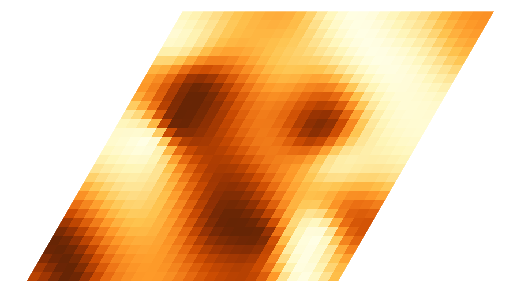

In [24]:
lat.coffee_plot(path[-1])
plt.show()